In [1]:
import pandas as pd
import numpy as np
from openpyxl import load_workbook
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [2]:
filename = "datasets/original_dataset.xlsx"
df = pd.read_excel(filename, engine='openpyxl')


# Separate data into training and validation sets
train_df = df[df['TrainVal'] == 'Train_60']
val_df = df[df['TrainVal'] == 'Val_40']
train_df

,UniqueID,submission_year,target,TrainVal,Long_1,Long_2,Long_3,Long_4,Long_5,Long_6,...,Short_1,Short_2,Short_3,Short_4,Short_5,Short_6,Short_7,Short_8,Short_9,Short_10
0,984TAH,2015,0,Train_60,1800.0,6.0,0.0,221.0,0.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,394ETK,2015,1,Train_60,700.0,1.0,0.0,147.0,17.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,036KQK,2015,0,Train_60,1700.0,2.0,0.0,461.0,187.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,996RNP,2015,0,Train_60,600.0,3.0,0.0,96.0,30.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,283LEL,2015,0,Train_60,200.0,3.0,0.0,218.0,190.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4592,430SZS,2017,0,Train_60,4200.0,4.0,5274.0,288.0,12.0,5.0,...,0.209001,0.346263,87.982786,6924.980000,83.649234,32882.36333,29662.59,87.799248,0.339166,0.000000
4593,993OMZ,2017,1,Train_60,4100.0,0.0,4698.0,175.0,8.0,5.0,...,0.425335,0.216075,60.127847,23132.485000,71.624812,45084.79333,23718.00,70.517402,0.514430,0.000000
4594,757VJZ,2017,0,Train_60,3000.0,14.0,0.0,414.0,37.0,10.5,...,0.138413,0.496467,71.118364,8192.698333,83.009946,184541.42500,131154.80,48.671647,0.061366,0.666667
4595,538JZF,2017,1,Train_60,1600.0,0.0,NaN,338.0,NaN,1.0,...,0.108609,0.630414,50.562971,41071.880000,73.326164,88518.18143,47621.34,58.136132,0.416919,0.000000


In [3]:

from sklearn.model_selection import KFold

kf = KFold(n_splits=2, shuffle=True, random_state=42)

X_train_old_list = []
X_train_new_list = []
X_train_full_list = []
y_train_list = []
valid_indices_list = [] 
for train_index, valid_index in kf.split(train_df):
    train_fold = train_df.iloc[train_index]
    valid_indices_list.append(valid_index)  # Store the validation indices

    # For old features model
    X_train_old = train_fold.drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal',
                                           'Short_1','Short_2','Short_3','Short_4','Short_5','Short_6',
                                           'Short_7','Short_8','Short_9', 'Short_10'])
    X_train_old_list.append(X_train_old)

    # For new features model
    X_train_new = train_fold.drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal',
                                           'Long_1','Long_2','Long_3','Long_4','Long_5','Long_6',
                                           'Long_7','Long_8','Long_9', 'Long_10'])
    X_train_new_list.append(X_train_new)

    # For full features model
    X_train_full = train_fold.drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal'])
    X_train_full_list.append(X_train_full)

    y_train = train_fold['target']
    y_train_list.append(y_train)


X_val_old = val_df.drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal',
                             'Short_1','Short_2','Short_3','Short_4','Short_5',
                             'Short_6','Short_7','Short_8','Short_9', 'Short_10'])
X_val_new = val_df.drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal',
                                 'Long_1','Long_2','Long_3','Long_4','Long_5','Long_6',
                                 'Long_7','Long_8','Long_9', 'Long_10'])
X_val_full= val_df.drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal'])
y_val = val_df['target']

# Model 1 (Old data)

In [4]:
# Train the XGBoost model with hyper parameter tuning
param_grid = {
    'learning_rate': [0.01,0.05,0.1],
    'max_depth': [2,3,4],
    'n_estimators': [50, 100, 150],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.7, 0.8, 0.9, 1]
    }
scores_old_list = []
scores_new_list = []
scores_full_list = []
oof_scores_old = np.zeros(len(train_df))
oof_scores_new = np.zeros(len(train_df))
oof_scores_full = np.zeros(len(train_df))
for idx in range(2):
    # Extract data for the current fold
    X_train_old = X_train_old_list[idx]
    y_train = y_train_list[idx]
    
    # Extract the "left-out" fold data for OOF predictions
    valid_index = valid_indices_list[idx]
    X_oof_old = train_df.iloc[valid_index].drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal',
                                                         'Short_1','Short_2','Short_3','Short_4','Short_5','Short_6',
                                                         'Short_7','Short_8','Short_9', 'Short_10'])
    y_oof = train_df['target'].iloc[valid_index]

    # Train the 'old' model
    clf_old = xgb.XGBClassifier()
    grid_search_old = GridSearchCV(clf_old, param_grid, scoring='roc_auc', cv=3, verbose=1)
    grid_search_old.fit(X_train_old, y_train)
    best_clf_old = grid_search_old.best_estimator_
    
    # OOF predictions
    oof_scores_old[valid_index] = best_clf_old.predict_proba(X_oof_old)[:, 1]
    
    # Predictions on the validation dataset
    scores_old = best_clf_old.predict_proba(X_val_old)[:, 1]
    scores_old_list.append(scores_old)





Fitting 3 folds for each of 324 candidates, totalling 972 fits
Fitting 3 folds for each of 324 candidates, totalling 972 fits


# Model 2 (New data)

In [5]:
# Train the XGBoost model with hyper parameter tuning

# Define the parameter grid
param_grid_new = {
    'learning_rate': [0.01,0.05,0.1],
    'max_depth': [2,3,4],
    'n_estimators': [50, 100, 150],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.7, 0.8, 0.9, 1]
    }

for idx in range(2):
    # Extract data for the current fold
    X_train_new = X_train_new_list[idx]
    y_train = y_train_list[idx]
    
    # Extract the "left-out" fold data for OOF predictions
    valid_index = valid_indices_list[idx]
    X_oof_new = train_df.iloc[valid_index].drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal',
                                                         'Long_1','Long_2','Long_3','Long_4','Long_5','Long_6',
                                           'Long_7','Long_8','Long_9', 'Long_10'])
    y_oof = train_df['target'].iloc[valid_index]

    clf_new = xgb.XGBClassifier()
    grid_search_new = GridSearchCV(clf_new, param_grid, scoring='roc_auc', cv=3, verbose=1)
    grid_search_new.fit(X_train_new, y_train)
    best_clf_new = grid_search_new.best_estimator_
    
    # OOF predictions
    oof_scores_new[valid_index] = best_clf_new.predict_proba(X_oof_new)[:, 1]
    
    # Predictions on the validation dataset
    scores_new = best_clf_new.predict_proba(X_val_new)[:, 1]
    scores_new_list.append(scores_new)


# Predict using the best model
# y_pred = best_clf.predict(X_val_new)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Fitting 3 folds for each of 324 candidates, totalling 972 fits


# Model 3 (New + Old data)

In [6]:
# Train the XGBoost model with hyper parameter tuning

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01,0.05,0.1],
    'max_depth': [2,3,4],
    'n_estimators': [50, 100, 150],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.7, 0.8, 0.9, 1]
    }

for idx in range(2):
    # Extract data for the current fold
    X_train_full= X_train_full_list[idx]
    y_train = y_train_list[idx]
    
    # Extract the "left-out" fold data for OOF predictions
    valid_index = valid_indices_list[idx]
    X_oof_full = train_df.iloc[valid_index].drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal'])
    y_oof = train_df['target'].iloc[valid_index]

    clf_full = xgb.XGBClassifier()
    grid_search_full= GridSearchCV(clf_full, param_grid, scoring='roc_auc', cv=3, verbose=1)
    grid_search_full.fit(X_train_full, y_train)
    best_clf_full = grid_search_full.best_estimator_
    
    # OOF predictions
    oof_scores_full[valid_index] = best_clf_full.predict_proba(X_oof_full)[:, 1]
    
    # Predictions on the validation dataset
    scores_full = best_clf_full.predict_proba(X_val_full)[:, 1]
    scores_full_list.append(scores_full)



Fitting 3 folds for each of 324 candidates, totalling 972 fits
Fitting 3 folds for each of 324 candidates, totalling 972 fits


# Merging probabilities from three models

In [7]:

# Convert OOF scores to DataFrame and add UniqueID
oof_scores_df_old = pd.DataFrame({'UniqueID': train_df['UniqueID'], 'OOF_Probability (Model old)': oof_scores_old})
oof_scores_df_new = pd.DataFrame({'UniqueID': train_df['UniqueID'], 'OOF_Probability (Model new)': oof_scores_new})
oof_scores_df_full = pd.DataFrame({'UniqueID': train_df['UniqueID'], 'OOF_Probability (Model full)': oof_scores_full})

# Average the validation scores across the folds
avg_val_scores_old = np.mean(scores_old_list, axis=0)
avg_val_scores_new = np.mean(scores_new_list, axis=0)
avg_val_scores_full = np.mean(scores_full_list, axis=0)

# Convert averaged validation scores to DataFrame and add UniqueID
val_scores_df_old = pd.DataFrame({'UniqueID': val_df['UniqueID'], 'Val_Probability (Model old)': avg_val_scores_old})
val_scores_df_new = pd.DataFrame({'UniqueID': val_df['UniqueID'], 'Val_Probability (Model new)': avg_val_scores_new})
val_scores_df_full = pd.DataFrame({'UniqueID': val_df['UniqueID'], 'Val_Probability (Model full)': avg_val_scores_full})

combined_scores_df_old = pd.concat([
    pd.DataFrame({'UniqueID': train_df['UniqueID'], 'Model_Old_Score': oof_scores_old}),
    pd.DataFrame({'UniqueID': val_df['UniqueID'], 'Model_Old_Score': avg_val_scores_old})
], axis=0)

combined_scores_df_new = pd.concat([
    pd.DataFrame({'UniqueID': train_df['UniqueID'], 'Model_New_Score': oof_scores_new}),
    pd.DataFrame({'UniqueID': val_df['UniqueID'], 'Model_New_Score': avg_val_scores_new})
], axis=0)

combined_scores_df_full = pd.concat([
    pd.DataFrame({'UniqueID': train_df['UniqueID'], 'Model_Full_Score': oof_scores_full}),
    pd.DataFrame({'UniqueID': val_df['UniqueID'], 'Model_Full_Score': avg_val_scores_full})
], axis=0)

# Merge combined scores with the original dataset
merged_df = df.copy()
merged_df = merged_df.merge(combined_scores_df_old, on='UniqueID', how='left')
merged_df = merged_df.merge(combined_scores_df_new, on='UniqueID', how='left')
merged_df = merged_df.merge(combined_scores_df_full, on='UniqueID', how='left')
merged_df

,UniqueID,submission_year,target,TrainVal,Long_1,Long_2,Long_3,Long_4,Long_5,Long_6,...,Short_4,Short_5,Short_6,Short_7,Short_8,Short_9,Short_10,Model_Old_Score,Model_New_Score,Model_Full_Score
0,984TAH,2015,0,Train_60,1800.0,6.0,0.0,221.0,0.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.279743,0.239507,0.346023
1,410VKN,2015,0,Val_40,5700.0,8.0,0.0,221.0,12.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.275325,0.241145,0.357211
2,394ETK,2015,1,Train_60,700.0,1.0,0.0,147.0,17.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.199404,0.239507,0.224328
3,036KQK,2015,0,Train_60,1700.0,2.0,0.0,461.0,187.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.180769,0.242782,0.095859
4,996RNP,2015,0,Train_60,600.0,3.0,0.0,96.0,30.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.304214,0.239507,0.295148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4594,757VJZ,2017,0,Train_60,3000.0,14.0,0.0,414.0,37.0,10.5,...,8192.698333,83.009946,184541.42500,131154.80,48.671647,0.061366,0.666667,0.311350,0.308557,0.373811
4595,538JZF,2017,1,Train_60,1600.0,0.0,NaN,338.0,NaN,1.0,...,41071.880000,73.326164,88518.18143,47621.34,58.136132,0.416919,0.000000,0.205242,0.217876,0.166487
4596,648WHI,2017,1,Val_40,100.0,3.0,6741.0,281.0,198.0,3.0,...,1587.646667,34.919227,35035.94000,32704.26,11.122347,0.064327,0.666667,0.256130,0.217986,0.220608
4597,899YZB,2017,1,Val_40,300.0,0.0,9411.0,173.0,44.0,1.0,...,15061.066670,42.615211,186000.48000,169718.98,39.008325,0.053133,0.666667,0.295684,0.243536,0.386402


# Use model output to build stacking model

In [8]:
aggregate_df = merged_df.drop(columns=['Short_1','Short_2','Short_3','Short_4','Short_5','Short_6',
                                 'Short_7','Short_8','Short_9', 'Short_10',
                                  'Long_1','Long_2','Long_3','Long_4','Long_5','Long_6',
                                 'Long_7','Long_8','Long_9', 'Long_10'])
aggregate_df

,UniqueID,submission_year,target,TrainVal,Model_Old_Score,Model_New_Score,Model_Full_Score
0,984TAH,2015,0,Train_60,0.279743,0.239507,0.346023
1,410VKN,2015,0,Val_40,0.275325,0.241145,0.357211
2,394ETK,2015,1,Train_60,0.199404,0.239507,0.224328
3,036KQK,2015,0,Train_60,0.180769,0.242782,0.095859
4,996RNP,2015,0,Train_60,0.304214,0.239507,0.295148
...,...,...,...,...,...,...,...
4594,757VJZ,2017,0,Train_60,0.311350,0.308557,0.373811
4595,538JZF,2017,1,Train_60,0.205242,0.217876,0.166487
4596,648WHI,2017,1,Val_40,0.256130,0.217986,0.220608
4597,899YZB,2017,1,Val_40,0.295684,0.243536,0.386402


In [9]:
# Separate data into training and validation sets
train_df_2 = aggregate_df[aggregate_df['TrainVal'] == 'Train_60']
val_df_2 = aggregate_df[aggregate_df['TrainVal'] == 'Val_40']

# Separate features and target variable
X_train_2 = train_df_2.drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal'])
y_train_2 = train_df_2['target']

X_val_2 = val_df_2.drop(columns=['UniqueID', 'submission_year', 'target', 'TrainVal'])
y_val_2 = val_df_2['target']
train_df_2

,UniqueID,submission_year,target,TrainVal,Model_Old_Score,Model_New_Score,Model_Full_Score
0,984TAH,2015,0,Train_60,0.279743,0.239507,0.346023
2,394ETK,2015,1,Train_60,0.199404,0.239507,0.224328
3,036KQK,2015,0,Train_60,0.180769,0.242782,0.095859
4,996RNP,2015,0,Train_60,0.304214,0.239507,0.295148
7,283LEL,2015,0,Train_60,0.120297,0.239507,0.095695
...,...,...,...,...,...,...,...
4592,430SZS,2017,0,Train_60,0.209461,0.263145,0.272550
4593,993OMZ,2017,1,Train_60,0.205034,0.221886,0.234009
4594,757VJZ,2017,0,Train_60,0.311350,0.308557,0.373811
4595,538JZF,2017,1,Train_60,0.205242,0.217876,0.166487


In [10]:
# Train the XGBoost model with hyper parameter tuning

# Define the parameter grid
param_grid_2 = {
    'learning_rate': [0.01,0.05,0.1],
    'max_depth': [2,3,4],
    'n_estimators': [50, 100, 150],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.7, 0.8, 0.9, 1]
    }
clf_2 = xgb.XGBClassifier()
grid_search_2 = GridSearchCV(clf_2, param_grid_2, scoring='roc_auc', cv=3, verbose=1)
grid_search_2.fit(X_train_2, y_train_2)

# Best hyperparameters
print(grid_search_2.best_params_)

best_clf_2 = grid_search_2.best_estimator_

Fitting 3 folds for each of 324 candidates, totalling 972 fits
{'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 50, 'subsample': 0.8}


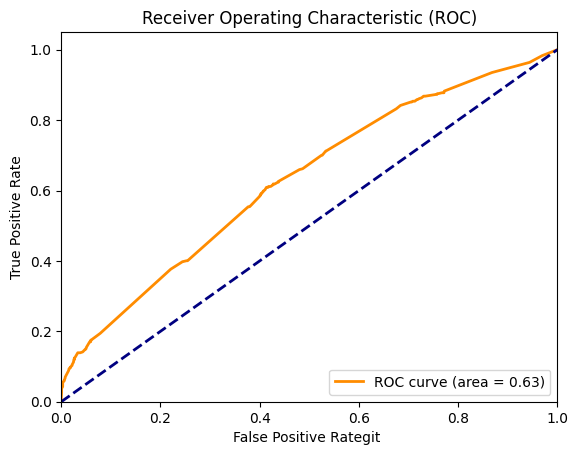

In [11]:
from sklearn.metrics import roc_curve, auc

# best_clf.fit(X_train_new, y_train)

# Predict on validation set

y_pred_2 = best_clf_2.predict_proba(X_val_2)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val_2, y_pred_2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rategit ')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('./images/ensembling.jpg')
plt.show()